# Previsão de Explosões Solares de classe >= M com horizonte de até 24h

## Instalando Pacotes

In [1]:
#!pip install torch==2.0.0 torchvision==0.15.1 torchaudio==2.0.1

#!pip install pytorch_lightning==1.9.0

#!pip install -U scikit-learn

#!pip install matplotlib

## Importação das bibliotecas

In [2]:
# interpretação de arquivos .csv e .xls
import pandas as pd

from collections import OrderedDict
import numpy as np

import torch
from torch.utils.data import DataLoader
from torch import nn

import torchvision
from torchvision import transforms

import pytorch_lightning
from pytorch_lightning import LightningModule, Trainer
from lightning_fabric.utilities.seed import seed_everything

# Para manipulação de imagens
from PIL import Image
from IPython.display import display

# Callback do Lightning para recuperar o melhor modelo com Checkpoints
from pytorch_lightning.callbacks import ModelCheckpoint

#Callback de early stopping
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

#Callback de monitorar LR
from pytorch_lightning.callbacks import LearningRateMonitor

torch.set_float32_matmul_precision('high')

seed_everything(seed=123)

Global seed set to 123


123

## Dataset e dataloader

### Criação dataset e do dataloader

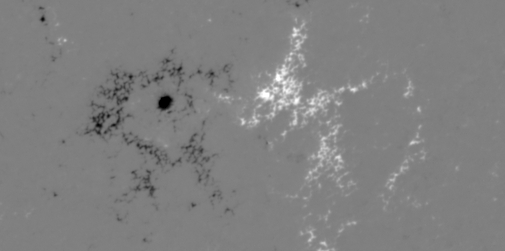

In [3]:
from PIL import Image
Image.open('../../../magnetogram_jpg/hmi.sharp_720s.1.20100504_160000_TAI.magnetogram.fits.jpg')

### Dataset

Aqui criamos um dataset sem aumento de dados

In [4]:
size_h = 224
size_w = 224
size_final = (size_h, size_w)

transform_train = transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(size=size_final, antialias=True),
    #torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

transform_valid = transform_train


In [5]:
class Mflare_Dataset(torch.utils.data.Dataset):
    def __init__(self, img_path, seq_path, csv, transform, etapa):
        self.img_path = img_path
        self.seq_path = seq_path
        self.csv = pd.read_csv(csv, delimiter=" ", header=None)
        self.seqs_list = self.csv.iloc[:, 0]
        self.labels = self.csv.iloc[:, 1]
        
        self.transform = transform
        self.etapa = etapa
        
        if self.etapa == 'train' or self.etapa == 'val':
            self.augs = self.csv.iloc[:, 2]

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):     
        seq = self.seqs_list[idx]       
        label = self.labels[idx].astype(np.int64)    
        #print(str(seq) + ' ' + str(label) + ' ' + str(flip))
        
        csv_seq = pd.read_csv(self.seq_path + seq, header=None)
        seq_list = csv_seq.iloc[:, 0]
       
        seq_imgs = torch.empty(size=(len(seq_list), size_h, size_w))
        
        for i in range(len(seq_list)):
            img = Image.open(self.img_path + seq_list[i] + '.fits.jpg')
            #img = ((img/np.max(img))*255).astype(np.uint8) 
            img = self.transform(img)
            #img = img.tile(3, 1, 1)
            
            if self.etapa == 'train' or self.etapa == 'val':
                aug = self.augs[idx]
                if aug == 'hf':
                    img = transforms.functional.hflip(img)
                elif aug == 'vf':
                    img = transforms.functional.vflip(img)
                elif aug == 'r1':
                    img = transforms.functional.rotate(img, angle=90)
                elif aug == 'r2':
                    img = transforms.functional.rotate(img, angle=180)
                elif aug == 'r3':
                    img = transforms.functional.rotate(img, angle=270)
                    
            seq_imgs[i] = img
        
        seq_imgs = seq_imgs.tile(3, 1, 1, 1)
        return seq_imgs, label

In [6]:
import os

# 5-fold Cross Validation
# Setar k entre 0 e 4

k = 3

n_train1 = k % 5
n_train2 = (k + 1) % 5
n_train3 = (k + 2) % 5
n_train4 = (k + 3) % 5
n_val = (k + 4) % 5

train1 = '../Seq16_flare_Mclass_24h_TrainVal' + str(n_train1) + '.txt '
train2 = '../Seq16_flare_Mclass_24h_TrainVal' + str(n_train2) + '.txt '
train3 = '../Seq16_flare_Mclass_24h_TrainVal' + str(n_train3) + '.txt'
train4 = '../Seq16_flare_Mclass_24h_TrainVal' + str(n_train4) + '.txt'
val = '../Seq16_flare_Mclass_24h_TrainVal' + str(n_val) + '.txt'

os.system('cat ' + train1 + train2 + train3 + ' > Seq16_flare_Mclass_24h_train1.txt') 
os.system('cat ' + val + ' > Seq16_flare_Mclass_24h_val1.txt')


0

# Oversample train and val

In [7]:
#arquivo de entrada com o caminho das imagens
def oversample(arq_entrada):
    arq = open(arq_entrada)
    linhas = arq.readlines()

    #nome para o arquivo de saída
    arq_saida =  arq_entrada + '_over'

    seq_entrada = []

    for linha in linhas:
        linha_res = linha.split()
        nf = linha_res[0] + ' ' + linha_res[1] + ' nf'
        seq_entrada.append(nf)

        #cria entrada para espelhamento horizontal e vertical na classe positiva
        if linha_res[1] == '1':
            hf = linha_res[0] + ' ' + linha_res[1] + ' hf'
            vf = linha_res[0] + ' ' + linha_res[1] + ' vf'
            r1 = linha_res[0] + ' ' + linha_res[1] + ' r1'
            r2 = linha_res[0] + ' ' + linha_res[1] + ' r2'
            r3 = linha_res[0] + ' ' + linha_res[1] + ' r3'
            seq_entrada.append(hf)
            seq_entrada.append(vf)
            seq_entrada.append(r1)
            seq_entrada.append(r2)
            seq_entrada.append(r3)

    with open(arq_saida, 'w') as fout:
        fout.write('\n'.join(f'{img}' for img in seq_entrada))

#oversample train
oversample('Seq16_flare_Mclass_24h_train1.txt')
#oversample val
oversample('Seq16_flare_Mclass_24h_val1.txt')

In [8]:
train_dataset = Mflare_Dataset('../../../magnetogram_jpg/','../Seqs16/','Seq16_flare_Mclass_24h_train1.txt_over', 
                                   transform=transform_train, etapa='train')
val_dataset = Mflare_Dataset('../../../magnetogram_jpg/','../Seqs16/','Seq16_flare_Mclass_24h_val1.txt_over', 
                                 transform=transform_valid, etapa='val')
test_dataset = Mflare_Dataset('../../../magnetogram_jpg/','../Seqs16/','../Seq16_flare_Mclass_24h_Test.txt', 
                                  transform=transform_valid, etapa='test')


In [9]:
dataset_size = len(train_dataset)
print(dataset_size)

34915


In [10]:
# Testando Batch 10, que estourava a memória da GPU local
batch_size = 10

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

print('Número de minibatches de trenamento:', len(train_dataloader))
print('Número de minibatches de validação:', len(val_dataloader))
print('Número de minibatches de teste:', len(test_dataloader))

x_train, y_train = next(iter(train_dataloader))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))


Número de minibatches de trenamento: 3492
Número de minibatches de validação: 1048
Número de minibatches de teste: 939

Dimensões dos dados de um minibatch: torch.Size([10, 3, 16, 224, 224])
Valores mínimo e máximo dos pixels:  tensor(0.) tensor(1.0000)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


torch.Size([3, 16, 224, 224])
torch.Size([224, 224])


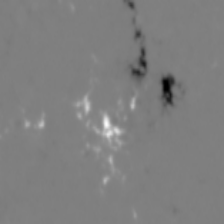

In [11]:
image = train_dataset[0][0]
print(image.size())
image = image[0][0]
print(image.size())
image = image.tile(3, 1, 1)
transforms.ToPILImage()(image)

Criação do modelo Pytorch Lightning

## Conhecendo a Rede

In [12]:
weights = torchvision.models.video.MViT_V2_S_Weights.DEFAULT
net = torchvision.models.video.mvit_v2_s(weights=weights)
net_name = net.__class__.__name__
net_name = net_name + '_S_10-7' #aggB'

print(net)
print(net_name)


MViT(
  (conv_proj): Conv3d(3, 96, kernel_size=(3, 7, 7), stride=(2, 4, 4), padding=(1, 3, 3))
  (pos_encoding): PositionalEncoding()
  (blocks): ModuleList(
    (0): MultiscaleBlock(
      (norm1): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
      (norm2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
      (attn): MultiscaleAttention(
        (qkv): Linear(in_features=96, out_features=288, bias=True)
        (project): Sequential(
          (0): Linear(in_features=96, out_features=96, bias=True)
        )
        (pool_q): Pool(
          (pool): Conv3d(96, 96, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=96, bias=False)
          (norm_act): Sequential(
            (0): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          )
        )
        (pool_k): Pool(
          (pool): Conv3d(96, 96, kernel_size=(3, 3, 3), stride=(1, 8, 8), padding=(1, 1, 1), groups=96, bias=False)
          (norm_act): Sequential(
            (0): LayerNorm((96,

## Normalização de pesos para Wloss

In [13]:
flaresRAsTrain = pd.read_csv('Seq16_flare_Mclass_24h_train1.txt_over', sep=' ', dtype='str')
flaresRAsVal = pd.read_csv('Seq16_flare_Mclass_24h_val1.txt_over', sep=' ', dtype='str')
flaresRAsTest = pd.read_csv('../Seq16_flare_Mclass_24h_Test.txt', sep=' ', dtype='str')

nSamplesPosTrain = flaresRAsTrain[flaresRAsTrain['0'] == '1']
nSamplesNegTrain = flaresRAsTrain[flaresRAsTrain['0'] == '0']
print('NSamplesTrain')
print(len(nSamplesPosTrain))
print(len(nSamplesNegTrain))

nSamplesPosVal = flaresRAsVal[flaresRAsVal['0'] == '1']
nSamplesNegVal = flaresRAsVal[flaresRAsVal['0'] == '0']
print('NSamplesVal')
print(len(nSamplesPosVal))
print(len(nSamplesNegVal))

nSamplesPosTest = flaresRAsTest[flaresRAsTest['0'] == '1']
nSamplesNegTest = flaresRAsTest[flaresRAsTest['0'] == '0']
print('NSamplesTest')
print(len(nSamplesPosTest))
print(len(nSamplesNegTest))


# Pesos para Loss - Treino
nSamplesTrain = [len(nSamplesNegTrain), len(nSamplesPosTrain)]
normedWeightsTrain = [1 - (x / sum(nSamplesTrain)) for x in nSamplesTrain]
normedWeightsTrain = torch.FloatTensor(normedWeightsTrain)

# Val
nSamplesVal = [len(nSamplesNegVal), len(nSamplesPosVal)]
normedWeightsVal = [1 - (x / sum(nSamplesVal )) for x in nSamplesVal ]
normedWeightsVal = torch.FloatTensor(normedWeightsVal)

# Test
nSamplesTest = [len(nSamplesNegTest), len(nSamplesPosTest)]
normedWeightsTest = [1 - (x / sum(nSamplesTest )) for x in nSamplesTest ]
normedWeightsTest = torch.FloatTensor(normedWeightsTest)

print(normedWeightsTrain)
print(normedWeightsVal)
print(normedWeightsTest)

NSamplesTrain
5898
29016
NSamplesVal
570
9904
NSamplesTest
195
9188
tensor([0.1689, 0.8311])
tensor([0.0544, 0.9456])
tensor([0.0208, 0.9792])


## Modelo do PyTorch Lightning

In [14]:
class MyLightningModule(LightningModule):
    def __init__(self, hparams):
        super().__init__()

        self.save_hyperparameters(hparams)
        self.criterionTrain = nn.CrossEntropyLoss(weight = normedWeightsTrain, reduction='none')
        self.criterionVal = nn.CrossEntropyLoss(weight = normedWeightsVal, reduction='none')
        self.criterionTest = nn.CrossEntropyLoss(weight = normedWeightsTest, reduction='none')

        #Importa o modelo 
        self.model = torchvision.models.video.mvit_v2_s(weights=weights)
              
        #Muda a última camada Linear(saída) para 2 classes
        self.model.head[1] = torch.nn.Linear(768, 2)

    def forward(self, x):
        logits = self.model(x)
        preds = logits.argmax(dim=1)
        return logits, preds

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch

        # predict da rede
        logits = self.model(x)

        # calcula a perda
        batch_losses = self.criterionTrain(logits, y)
        loss = batch_losses.mean()

        # O PL sempre espera um retorno nomeado 'loss' da training_step.
        return {'loss': loss, 'batch_losses': batch_losses}

    def training_epoch_end(self, outputs):
        avg_loss = torch.cat([output['batch_losses'] for output in outputs]).mean()

        return

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch

        # predict da rede
        logits, preds = self.forward(x)

        # calcula a perda
        batch_losses = self.criterionVal(logits, y)
        # calcula a acurácia
        batch_accuracy = (preds == y)

        # Retornamos as losses do batch para podermos fazer a média no validation_epoch_end.
        return {'batch_losses': batch_losses, 'batch_accuracy': batch_accuracy}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.cat([output['batch_losses'] for output in outputs]).mean()
        accuracy = torch.cat([output['batch_accuracy'] for output in outputs]).float().mean()

        self.log('valid_loss', avg_loss.item(), prog_bar=True, sync_dist=True)
        self.log('valid_accuracy', accuracy.item(), prog_bar=True, sync_dist=True)

    def test_step(self, val_batch, batch_idx):
        # A implementação deste método é opcional no Pytorch Lightning.
        x, y = val_batch

        # predict da rede
        logits, preds = self.forward(x)

        # calcula a perda
        batch_losses = self.criterionTest(logits, y)
        # calcula a acurácia
        batch_accuracy = (preds == y)

        # Retornamos as losses do batch para podermos fazer a média no validation_epoch_end.
        return {'batch_losses': batch_losses, 'batch_accuracy': batch_accuracy}

    def test_epoch_end(self, outputs):
        # A implementação deste método é opcional no Pytorch Lightning.
        avg_loss = torch.cat([output['batch_losses'] for output in outputs]).mean()
        accuracy = torch.cat([output['batch_accuracy'] for output in outputs]).float().mean()

        self.log('test_loss', avg_loss.item(), sync_dist=True)
        self.log('test_accuracy', accuracy.item(), sync_dist=True)

    def configure_optimizers(self):
        # Gradiente descendente
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.hparams['learning_rate'])

        #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
        #return [optimizer], [scheduler]  # Forma de retorno para associar um otimizador a um scheduler.
        
        #Reduzir LR no Plato
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, min_lr=1e-10, verbose=True)
        
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": 'valid_loss'}

## Treinamento e Validação

In [15]:
# Hiperparâmetros
hparams = {
    'max_epochs': 100,
    'learning_rate': 0.0000001,
    'pretrained': True,
    'augmentation': False
}


# Cria o modelo Lightning
pl_model = MyLightningModule(hparams=hparams)

# Init ModelCheckpoint callback, monitoring 'valid_loss'
checkpoint_callback = ModelCheckpoint(
    monitor='valid_loss',
    dirpath='./',
    filename='sample-FLARE_' + net_name + '-{epoch:02d}-{valid_loss:.2f}-Wloss_k=' + str(k),
    save_top_k=3,
    mode='min',
)

#Early stopping callback monitoring 'valid_loss'
early_stop_callback = EarlyStopping(monitor="valid_loss", patience=10, verbose=True, mode="min")

#LR monitor callback
lr_monitor = LearningRateMonitor(logging_interval='step')

# Add your callbacks to the callbacks list
trainer = Trainer(callbacks=[checkpoint_callback, early_stop_callback, lr_monitor],
                  max_epochs=hparams['max_epochs'], accelerator='gpu', devices=1) #, accumulate_grad_batches=10')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [16]:
# Treina o modelo
#trainer.fit(pl_model, train_dataloader, val_dataloader)

In [17]:
# Retrieve checkpoint
#best_model = checkpoint_callback.best_model_path

#Forcing Best Model
best_model = "sample-FLARE_MViT_S_10-7-epoch=08-valid_loss=0.03-Wloss_k=3_save.ckpt"
print(best_model)

sample-FLARE_MViT_S_10-7-epoch=08-valid_loss=0.03-Wloss_k=3_save.ckpt


## Conferindo o Modelo Treinado --> Agora OK.

In [18]:
print(pl_model)

MyLightningModule(
  (criterionTrain): CrossEntropyLoss()
  (criterionVal): CrossEntropyLoss()
  (criterionTest): CrossEntropyLoss()
  (model): MViT(
    (conv_proj): Conv3d(3, 96, kernel_size=(3, 7, 7), stride=(2, 4, 4), padding=(1, 3, 3))
    (pos_encoding): PositionalEncoding()
    (blocks): ModuleList(
      (0): MultiscaleBlock(
        (norm1): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
        (norm2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
        (attn): MultiscaleAttention(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (project): Sequential(
            (0): Linear(in_features=96, out_features=96, bias=True)
          )
          (pool_q): Pool(
            (pool): Conv3d(96, 96, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=96, bias=False)
            (norm_act): Sequential(
              (0): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            )
          )
          (pool_k): Pool(
 

## Testando (Treino, Validação, Teste)

In [19]:
#trainer.test(test_model, train_dataloader)

In [20]:
#trainer.test(test_model, val_dataloader)

In [21]:
# Carrega melhor modelo
test_model = MyLightningModule.load_from_checkpoint(best_model, hparams=hparams)

/home/lgrim/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/migration/utils.py:49: PossibleUserWarning: The loaded checkpoint was produced with Lightning v1.9.4, which is newer than your current Lightning version: v1.9.0
  rank_zero_warn(


In [22]:
import time

start = time.time()

trainer.test(test_model, test_dataloader)

end = time.time()
print(end - start)

Missing logger folder: /home/lgrim/Seq_Magnetogram/M24/SF_MViT_oTV/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9168798327445984
        test_loss           0.01761276088654995
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
548.5662949085236


## Precision, Recall, F1 Score do SKLearn e EER

In [23]:
# Imports para as Métricas
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Modifiquei para adcionar a variável "usecpu"
if torch.cuda.is_available(): 
   dev = "cuda:0"
   cpu = "cpu"
else: 
   dev = "cpu" 
   cpu = "cpu"
print(dev)

device = torch.device(dev)
usecpu = torch.device(cpu)

cuda:0


### Funções para Predições e Métricas

In [24]:
def predicoes(dataloader, modelo):
    modelo.eval()
    with torch.no_grad():
        y_true = torch.tensor([])
        y_pred = torch.tensor([])
        pred_scores = torch.tensor([])

        modelo = modelo.to(device)
        y_true = y_true.to(device)
        y_pred = y_pred.to(device)
        pred_scores = pred_scores.to(device)

        for x, y in iter(dataloader):
            x = x.to(device)
            y = y.to(device)
            with torch.no_grad(): # predict da rede
                logits = modelo.forward(x)
                pred = torch.argmax(logits, dim=1)
                scores_pred = torch.nn.Softmax(dim=1)(logits)

            y_true = torch.cat((y_true, y))
            y_pred = torch.cat((y_pred, pred))
            pred_scores = torch.cat((pred_scores, scores_pred))

    return y_true, y_pred, pred_scores

In [25]:
from datetime import datetime

def metricas(dataloader, model, suff):
    # Para poder utilizar as métricas do sklearn e do pandas
    y_true, y_pred, pred_scores = predicoes(dataloader, model)

    # Envia os dados de volta para a memória da CPU
    y_true = y_true.to(usecpu)
    y_pred = y_pred.to(usecpu)
    pred_scores = pred_scores.to(usecpu)

    print('Matriz de confusão:')
    crosstab = pd.crosstab(y_pred, y_true, rownames=['Pred'], colnames=['True'])

    print(crosstab)
    tn = crosstab.iloc[0, 0]
    tp = crosstab.iloc[1, 1]
    fn = crosstab.iloc[0, 1]
    fp = crosstab.iloc[1, 0]

    Acc = (tp + tn) / (tp + fp + tn + fn)
    Pod = tp / (tp + fn)
    Pre = tp / (tp + fp)
    Far = fp / (tp + fp)
    Csi = tp / (tp + fp + fn)
    F1 = (2 * Pre * Pod) / (Pre + Pod)
    Hss = (2 * (tp * tn - fp * fn)) / ((tp + fn) * (fn + tn) + (tp + fp) * (fp + tn))
    Tss = (tp / (tp + fn)) - (fp / (fp + tn))

    print('\n')

    print('F1  = {:.2f}'.format(F1))
    print('ACC = {:.2f}'.format(Acc))
    print('POD = {:.2f}'.format(Pod))
    print('PRE = {:.2f}'.format(Pre))
    print('FAR = {:.2f}'.format(Far))
    print('CSI = {:.2f}'.format(Csi))
    print('HSS = {:.2f}'.format(Hss))
    print('TSS = {:.2f}'.format(Tss))

    print('\n')

    print(classification_report(y_true, y_pred, digits=4))

    pc = (tp + fn) / (tn + fp ) * 100
    dh = datetime.now()
    dh = dh.strftime('%Y/%m/%d %H:%M')


    with open(net_name + suff, 'a') as fout:
        fout.write(dh + ' ' + str(k) + ' ' + net_name + ' ' + '{:.2f}'.format(pc) +  ' ' + '{:.2f}'.format(F1) + ' ' +
                   '{:.2f}'.format(Acc) + ' ' + '{:.2f}'.format(Pod) + ' ' + '{:.2f}'.format(Pre) + ' ' + '{:.2f}'.format(Far) +
                   ' ' + '{:.2f}'.format(Csi) + ' ' + '{:.2f}'.format(Hss) + ' ' + '{:.2f}'.format(Tss) + '\n')


### Métricas do Treino

In [26]:
#metricas(train_dataloader, test_model.model, '_train')

### Métricas da Validação

In [27]:
#metricas(val_dataloader, test_model.model, '_val')

### Métricas do Teste

In [28]:
start = time.time()

metricas(test_dataloader, test_model.model, '_test')

end = time.time()
print(end - start)

Matriz de confusão:
True   0.0  1.0
Pred           
0.0   8441   32
1.0    748  163


F1  = 0.29
ACC = 0.92
POD = 0.84
PRE = 0.18
FAR = 0.82
CSI = 0.17
HSS = 0.27
TSS = 0.75


              precision    recall  f1-score   support

         0.0     0.9962    0.9186    0.9558      9189
         1.0     0.1789    0.8359    0.2948       195

    accuracy                         0.9169      9384
   macro avg     0.5876    0.8772    0.6253      9384
weighted avg     0.9792    0.9169    0.9421      9384

408.584285736084


# Com CPU

In [29]:
def predicoes(dataloader, modelo):
    modelo.eval()
    with torch.no_grad():
        y_true = torch.tensor([])
        y_pred = torch.tensor([])
        pred_scores = torch.tensor([])

        modelo = modelo.to(usecpu)
        y_true = y_true.to(usecpu)
        y_pred = y_pred.to(usecpu)
        pred_scores = pred_scores.to(usecpu)

        for x, y in iter(dataloader):
            x = x.to(usecpu)
            y = y.to(usecpu)
            with torch.no_grad(): # predict da rede
                logits = modelo.forward(x)
                pred = torch.argmax(logits, dim=1)
                scores_pred = torch.nn.Softmax(dim=1)(logits)

            y_true = torch.cat((y_true, y))
            y_pred = torch.cat((y_pred, pred))
            pred_scores = torch.cat((pred_scores, scores_pred))

    return y_true, y_pred, pred_scores

In [30]:
start = time.time()

metricas(test_dataloader, test_model.model, '_test_cpu')

end = time.time()
print(end - start)

Matriz de confusão:
True   0.0  1.0
Pred           
0.0   8441   32
1.0    748  163


F1  = 0.29
ACC = 0.92
POD = 0.84
PRE = 0.18
FAR = 0.82
CSI = 0.17
HSS = 0.27
TSS = 0.75


              precision    recall  f1-score   support

         0.0     0.9962    0.9186    0.9558      9189
         1.0     0.1789    0.8359    0.2948       195

    accuracy                         0.9169      9384
   macro avg     0.5876    0.8772    0.6253      9384
weighted avg     0.9792    0.9169    0.9421      9384

11591.867006063461
